In [41]:
import warnings
from sklearn.metrics import classification_report, accuracy_score

import pandas as pd
import numpy as np
from numpy import pi
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from collections import Counter
from cycler import cycler
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# To build models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle
warnings.filterwarnings("ignore")
# To measure time
from time import time

In [43]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine boths dataframes
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Create label
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(train_df.shape))
print('Shape Test:\t{}\n'.format(test_df.shape))

train_df.head()

Shape Train:	(7352, 564)
Shape Test:	(2947, 564)



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Data
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,Train
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,Train
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING,Train
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING,Train
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING,Train


In [44]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in both_df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [45]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Data
dtypes: float64(561), object(2)
memory usage: 44.2+ MB


In [46]:
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

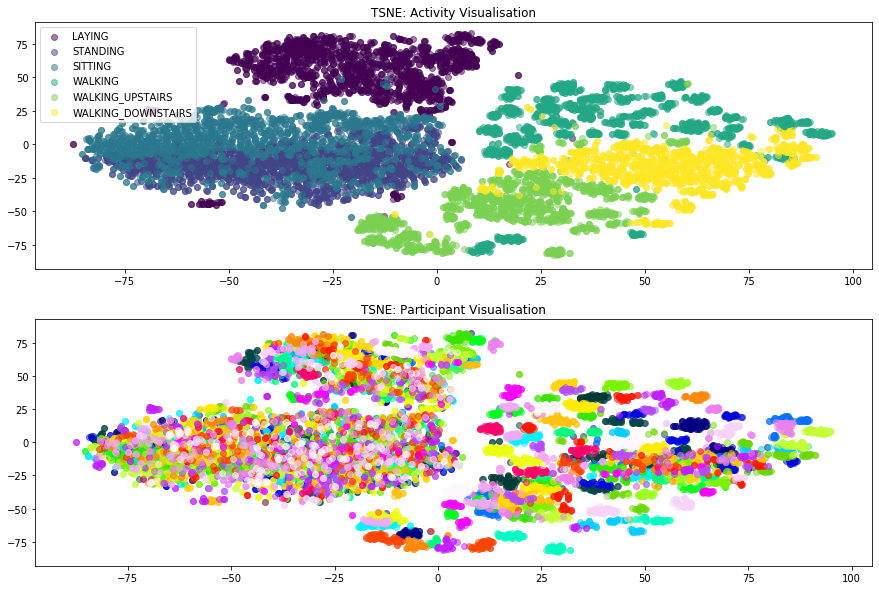

In [47]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

In [50]:
enc = LabelEncoder()
label_encoded = enc.fit_transform(label)
X_train, X_test, y_train, y_test = train_test_split(tsne_data, label_encoded, random_state=0)

### Decision Tree Classifier

In [49]:
from sklearn.tree import DecisionTreeClassifier

In [51]:
## DT
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [52]:
##save model
filename_DT = 'DT_model.sav'
pickle.dump(classifier, open(filename_DT, 'wb'))

In [53]:
## loaded 
loaded_model = pickle.load(open(filename_DT, 'rb'))
## predit data from model
y_pred = loaded_model.predict(X_test)

In [54]:
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8283495145631068


In [55]:
# 0-> Laying
# 1-> Standing
# 2 -> Sitting
# 3-> Walking
# 4-> Walking_Upstairs
# 5-> Walking_Downstairs
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       476
           1       0.73      0.74      0.73       465
           2       0.76      0.75      0.76       489
           3       0.82      0.86      0.84       407
           4       0.84      0.79      0.82       346
           5       0.84      0.84      0.84       392

    accuracy                           0.83      2575
   macro avg       0.83      0.83      0.83      2575
weighted avg       0.83      0.83      0.83      2575



### Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
random.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
##save model
filename_RF = 'RF_model.sav'
pickle.dump(random, open(filename_RF, 'wb'))

In [59]:
## loaded 
loaded_model_RF = pickle.load(open(filename_RF, 'rb'))
## predit data from model
y_pred = loaded_model_RF.predict(X_test)

In [60]:
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.8947572815533981


In [61]:
# 0-> Laying
# 1-> Standing
# 2 -> Sitting
# 3-> Walking
# 4-> Walking_Upstairs
# 5-> Walking_Downstairs
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       476
           1       0.80      0.85      0.83       465
           2       0.87      0.81      0.84       489
           3       0.90      0.94      0.92       407
           4       0.91      0.87      0.89       346
           5       0.93      0.91      0.92       392

    accuracy                           0.89      2575
   macro avg       0.90      0.90      0.90      2575
weighted avg       0.90      0.89      0.89      2575



### Support Vector Machine

In [62]:
from sklearn.svm import SVC

In [63]:
svm = SVC(gamma = 'auto', random_state = 0)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [64]:
##save model
filename_SVM = 'SVM_model.sav'
pickle.dump(svm, open(filename_SVM, 'wb'))

In [65]:
## loaded 
loaded_model_SVM = pickle.load(open(filename_SVM, 'rb'))
## predit data from model
y_pred = loaded_model_SVM.predict(X_test)

In [66]:
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9250485436893204


In [67]:
# 0-> Laying
# 1-> Standing
# 2 -> Sitting
# 3-> Walking
# 4-> Walking_Upstairs
# 5-> Walking_Downstairs
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       476
           1       0.94      0.90      0.92       465
           2       0.94      0.92      0.93       489
           3       0.99      0.89      0.94       407
           4       0.73      0.99      0.84       346
           5       0.99      0.91      0.95       392

    accuracy                           0.93      2575
   macro avg       0.93      0.93      0.92      2575
weighted avg       0.94      0.93      0.93      2575



### Naive Bayes

In [68]:
from sklearn.naive_bayes import GaussianNB

In [69]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
##save model
filename_NB = 'NB_model.sav'
pickle.dump(nb, open(filename_NB, 'wb'))

In [71]:
## loaded 
loaded_model_nb = pickle.load(open(filename_NB, 'rb'))
## predit data from model
y_pred = loaded_model_nb.predict(X_test)

In [72]:
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.821747572815534


In [73]:
# 0-> Laying
# 1-> Standing
# 2 -> Sitting
# 3-> Walking
# 4-> Walking_Upstairs
# 5-> Walking_Downstairs
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       476
           1       0.88      0.72      0.79       465
           2       0.80      0.88      0.84       489
           3       0.84      0.83      0.83       407
           4       0.60      0.67      0.63       346
           5       0.80      0.87      0.83       392

    accuracy                           0.82      2575
   macro avg       0.82      0.82      0.81      2575
weighted avg       0.83      0.82      0.82      2575



### K Nearest Neighbors

In [74]:
from sklearn.neighbors import KNeighborsClassifier

In [75]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [76]:
##save model
filename_KNN = 'KNN_model.sav'
pickle.dump(knn, open(filename_KNN, 'wb'))

In [77]:
## loaded 
loaded_model_KNN = pickle.load(open(filename_KNN, 'rb'))
## predit data from model
y_pred = loaded_model_KNN.predict(X_test)

In [78]:
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

Accuracy: 0.9522330097087378


In [79]:
# 0-> Laying
# 1-> Standing
# 2 -> Sitting
# 3-> Walking
# 4-> Walking_Upstairs
# 5-> Walking_Downstairs
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.88      0.91      0.90       465
           2       0.92      0.88      0.90       489
           3       0.96      1.00      0.98       407
           4       0.99      0.96      0.98       346
           5       0.99      0.98      0.98       392

    accuracy                           0.95      2575
   macro avg       0.96      0.95      0.95      2575
weighted avg       0.95      0.95      0.95      2575

